In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


sns.set()

# Analyse Sales

In [2]:
raw_data = pd.read_csv("data/sales.csv", index_col=0)

sales = raw_data.copy()
sales.head()

,date,customer_id,product,license_type,quantity,stock_price_usd,final_price_usd,discount_percent,year,month,week,day
1,2019-01-01,796915.0,IDE-2,New,19,283.1,172.691,39,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
2,2019-01-01,796915.0,IDE-1,Renew,22,1097.8,625.746,43,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
3,2019-01-01,796915.0,IDE-1,Renew,89,4441.1,399.699,91,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
4,2019-01-01,702505.0,IDE-1,New,51,25449.0,12978.990,49,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
5,2019-01-01,702505.0,IDE-2,New,94,14006.0,8263.540,41,2019,2019-01,2018-12-31/2019-01-06,2019-01-01


In [3]:
# Check if there are some nan values
sales.isna().sum()

date                0
customer_id         0
product             0
license_type        0
quantity            0
stock_price_usd     0
final_price_usd     0
discount_percent    0
year                0
month               0
week                0
day                 0
dtype: int64

In [4]:
# Add new columns for better aggregation

sales["date"] = pd.to_datetime(sales["date"])

sales["year"] = sales["date"].dt.year
sales["month"] = sales["date"].dt.to_period("M")
sales["week"] = sales["date"].dt.to_period("W")
sales["day"] = sales["date"].dt.to_period("D")

sales.head()

,date,customer_id,product,license_type,quantity,stock_price_usd,final_price_usd,discount_percent,year,month,week,day
1,2019-01-01,796915.0,IDE-2,New,19,283.1,172.691,39,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
2,2019-01-01,796915.0,IDE-1,Renew,22,1097.8,625.746,43,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
3,2019-01-01,796915.0,IDE-1,Renew,89,4441.1,399.699,91,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
4,2019-01-01,702505.0,IDE-1,New,51,25449.0,12978.990,49,2019,2019-01,2018-12-31/2019-01-06,2019-01-01
5,2019-01-01,702505.0,IDE-2,New,94,14006.0,8263.540,41,2019,2019-01,2018-12-31/2019-01-06,2019-01-01


In [5]:
clion_indices = sales.index[sales["product"] == "IDE-1"]

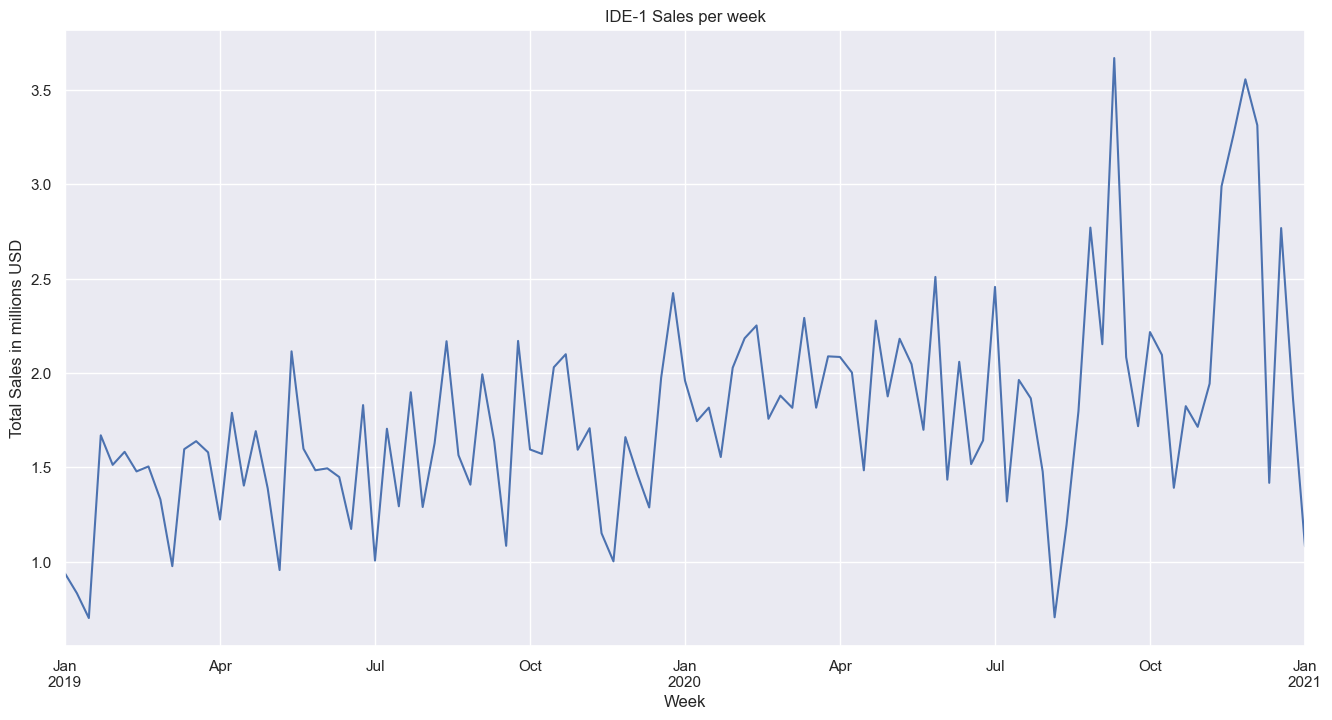

In [ ]:
# Plot sales line chart

(sales.loc[clion_indices].groupby(["week"])["final_price_usd"].sum() / 10**6).plot(
    figsize=(16, 8)
)

plt.title("IDE-1 Sales per week")
plt.xlabel("Week")
plt.ylabel("Total Sales in millions USD")


plt.savefig("images/sales_per_week.png")

In [7]:
# Revenue Tables

revenue_per_year_and_product = sales.groupby(["year", "product"]).agg(
    {
        "customer_id": [("number of sales", "count")],
        "final_price_usd": [("revenue in MM usd", lambda value: sum(value) / 10**6)],
    }
)

revenue_per_year_and_product.head(6)

customer_id   final_price_usd
             number of sales revenue in MM usd
year product                                  
2019 IDE-1             17823         79.913226
     IDE-2             17553         77.974749
     IDE-3             17503         79.201958
2020 IDE-1             23478        106.123518
     IDE-2             23098        102.605970
     IDE-3             23601        106.103977

In [8]:
year_to_year_revenue = (
    revenue_per_year_and_product.loc[2020] / revenue_per_year_and_product.loc[2019] - 1
)

year_to_year_revenue.loc["mean"] = year_to_year_revenue.mean()

year_to_year_revenue.head()

,customer_id,final_price_usd
,number of sales,revenue in MM usd
product,,
IDE-1,0.317287,0.327984
IDE-2,0.315900,0.315887
IDE-3,0.348397,0.339664
mean,0.327195,0.327845


In [9]:
revenue_per_year_and_product.columns = (
    revenue_per_year_and_product.columns.get_level_values(1)
)

revenue_per_year_and_product.head(6)

number of sales  revenue in MM usd
year product                                    
2019 IDE-1              17823          79.913226
     IDE-2              17553          77.974749
     IDE-3              17503          79.201958
2020 IDE-1              23478         106.123518
     IDE-2              23098         102.605970
     IDE-3              23601         106.103977

In [10]:
# See if there is a difference between New and Renew

renew_vs_new = sales.groupby(["year", "product", "license_type"]).agg(
    {"customer_id": [("number of sales", "count")]}
)

renew_vs_new.head(12)

customer_id
                          number of sales
year product license_type                
2019 IDE-1   New                     8955
             Renew                   8868
     IDE-2   New                     8806
             Renew                   8747
     IDE-3   New                     8773
             Renew                   8730
2020 IDE-1   New                    11850
             Renew                  11628
     IDE-2   New                    11421
             Renew                  11677
     IDE-3   New                    11817
             Renew                  11784

In [11]:
# Check discounts distibution and patterns

discounts_distribution = sales.groupby(["discount_percent"])["discount_percent"].count()

discounts_distribution.to_numpy()

array([ 582, 1272, 1218, 1229, 1245, 1240, 1261, 1214, 1204, 1204, 1187,
       1212, 1249, 1263, 1243, 1220, 1236, 1276, 1286, 1267, 1246, 1195,
       1158, 1225, 1197, 1165, 1181, 1269, 1237, 1211, 1166, 1239, 1219,
       1279, 1294, 1210, 1229, 1280, 1204, 1224, 1206, 1248, 1225, 1205,
       1265, 1262, 1246, 1207, 1216, 1254, 1187, 1228, 1251, 1251, 1252,
       1231, 1233, 1273, 1233, 1276, 1173, 1264, 1262, 1283, 1201, 1192,
       1239, 1177, 1213, 1250, 1168, 1266, 1220, 1251, 1263, 1307, 1196,
       1184, 1274, 1223, 1329, 1275, 1230, 1241, 1178, 1253, 1207, 1273,
       1255, 1164, 1173, 1155, 1240, 1220, 1190, 1201, 1276, 1227, 1208,
       1250,  620])

## Forecasting

We need to answer several questions first:
- Is the time series stationary?
- If not stationary, what should we do to make it stationary?
- Is the time series seasonal?
- If seasonal, what is the period?
- What is the AR and MA orders to use? 
- What is the Integrational d order to use?

In [12]:
# Is the time series stationary?

sales_per_week = (
    sales.loc[clion_indices].groupby(["week"]).agg({"final_price_usd": ["sum"]})
)
sales_per_week = pd.DataFrame(
    sales_per_week.reset_index().values, columns=["week", "revenue"]
).set_index("week")
sales_per_week.index = sales_per_week.index.to_timestamp()

sts.adfuller(sales_per_week)

(-0.6617952852704483,
 0.8563988467939556,
 10,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 2648.442908646669)

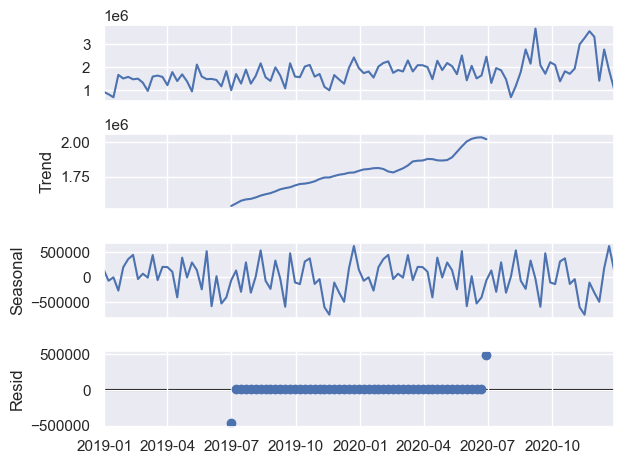

In [ ]:
seasonal_decompose_additive = seasonal_decompose(sales_per_week, model="additive")

seasonal_decompose_additive.plot()

- There is a upward trend on sales. Time series is not stationary;
- There is a seasonality with T = 12 months.

In [14]:
results = {}

test_series = sales_per_week.copy()
for d in range(6):
    adf_result = sts.adfuller(test_series, autolag="AIC")
    test_series = test_series.diff().dropna()
    adf_stationary = adf_result[1] <= 0.05

    results[d] = (adf_result[1], adf_stationary)

    results_df = pd.DataFrame.from_dict(
        results, orient="index", columns=["adf_stats", "is_adf_stationary"]
    )

results_df.head(6)

,adf_stats,is_adf_stationary
0,8.563988e-01,False
1,2.677915e-09,True
2,5.863930e-09,True
3,9.208381e-09,True
4,3.955215e-10,True
5,3.119979e-09,True


It is enough to apply differencing only once to get a stationarity.

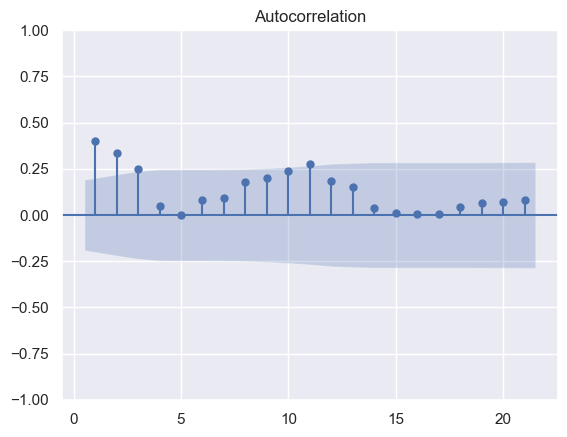

In [15]:
sgt.plot_acf(sales_per_week, zero=False);

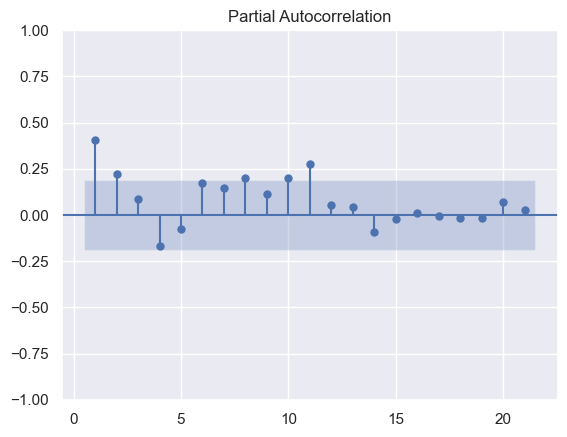

In [ ]:
## See if there is an autoregression on lags and constant

sgt.plot_pacf(sales_per_week, zero=False, method="ols")

In [17]:
sales_per_week_adj = sales_per_week.diff().dropna()

sales_per_week_adj.head()

,revenue
week,
2019-01-07,-104812.787
2019-01-14,-131379.04
2019-01-21,968480.137
2019-01-28,-156542.635
2019-02-04,69049.707


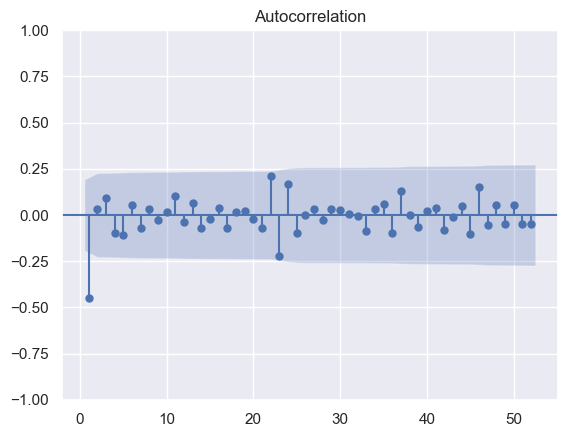

In [ ]:
sgt.plot_acf(sales_per_week_adj, zero=False, lags=52)

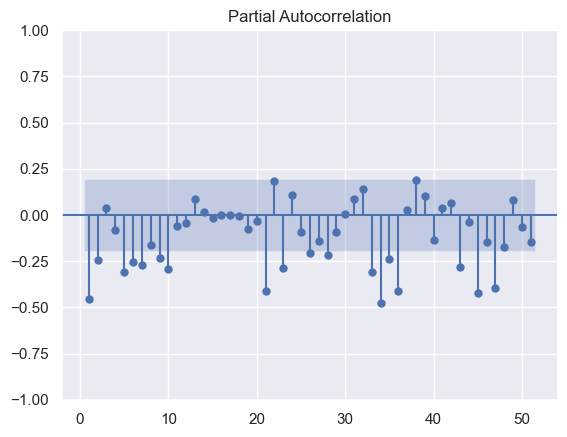

In [ ]:
sgt.plot_pacf(sales_per_week_adj, zero=False, lags=51, method="ols")

The results are a bit confusing, let's apply estimation of p, q parameters, we use AIC as a measure. 

In [20]:
params_measures = []

for p in range(6):
    for q in range(6):
        # we already know that d = 1
        model = SARIMAX(
            sales_per_week.astype(float),
            order=(p, 1, q),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = model.fit()

        params_measures.append((p, q, results.aic, results.bic))

orders = pd.DataFrame(params_measures, columns=["p", "q", "AIC", "BIC"])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44306D+01    |proj g|=  3.19746D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.197D-08   1.443D+01
  F =   14.430622191797344     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76963D+02    |proj g|=  4.26031D+02

At iterate    5    f=  1.41166D+01    |proj g|=  6.60473D-01

At iterate   10    f=  1.41115D+01    |proj g|=  2.45191D-01

At iterate   15    f=  1.40823D+01    |proj g|=  9.04170D-02

At iterate   20    f=  1.40811D+01    |proj g|=  2.11560D-01

At iterate   25    f=  1.40740D+01    |proj g|=  2.20932D-01


 This problem is unconstrained.



At iterate   30    f=  1.40737D+01    |proj g|=  1.80419D-03

At iterate   35    f=  1.40737D+01    |proj g|=  6.27875D-02

At iterate   40    f=  1.40734D+01    |proj g|=  2.22200D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     62      1     0     0   1.848D-03   1.407D+01
  F =   14.073420115754546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21605D+02    |proj g|=  7.30921D+03

At iterate    5    f=  1.38379D+01    |proj g|=  3.35505D-01

At iterate   10    f=  1.37426D+01    |proj g|=  3.57903D-01

At iterate   15    f=  1.35302D+01    |proj g|=  8.94258D-02

At iterate   20    f=  1.35245D+01    |proj g|=  6.62566D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     44      1     0     0   3.595D-05   1.352D+01
  F =   13.524488090473785     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  1.39535D+01    |proj g|=  5.16409D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     40      1     0     0   1.974D-06   1.395D+01
  F =   13.953534645258989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38408D+01    |proj g|=  2.14814D-01

At iterate    5    f=  1.38261D+01    |proj g|=  6.65260D-02

At iterate   10    f=  1.38091D+01    |proj g|=  3.33478D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   1.504D-05   1.381D+01
  F =   13.808877706435048     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74337D+02    |proj g|=  1.08380D+03


 This problem is unconstrained.



At iterate    5    f=  1.38602D+01    |proj g|=  7.50606D-01

At iterate   10    f=  1.38509D+01    |proj g|=  5.18030D+00

At iterate   15    f=  1.37154D+01    |proj g|=  5.75184D+00

At iterate   20    f=  1.36685D+01    |proj g|=  9.75640D-01

At iterate   25    f=  1.36478D+01    |proj g|=  1.87615D+00

At iterate   30    f=  1.36447D+01    |proj g|=  8.88723D-01

At iterate   35    f=  1.36426D+01    |proj g|=  9.17595D-01

At iterate   40    f=  1.36410D+01    |proj g|=  8.35610D-01

At iterate   45    f=  1.36396D+01    |proj g|=  9.72474D-01

At iterate   50    f=  1.36386D+01    |proj g|=  5.58958D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  1.35312D+01    |proj g|=  9.27103D-02

At iterate   20    f=  1.35284D+01    |proj g|=  5.51551D-03

At iterate   25    f=  1.35283D+01    |proj g|=  5.51694D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     41      1     0     0   3.990D-05   1.353D+01
  F =   13.528311440233596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41562D+01    |proj g|=  6.35705D-06

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.39858D+01    |proj g|=  1.18063D-01

At iterate   15    f=  1.39753D+01    |proj g|=  9.55529D-03

At iterate   20    f=  1.39549D+01    |proj g|=  7.17750D-02

At iterate   25    f=  1.39520D+01    |proj g|=  2.85914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     67      1     0     0   1.631D-05   1.395D+01
  F =   13.951790040426493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.38211D+01    |proj g|=  2.08847D-01

At iterate   10    f=  1.38065D+01    |proj g|=  4.10379D-02

At iterate   15    f=  1.37726D+01    |proj g|=  3.95087D-01

At iterate   20    f=  1.37699D+01    |proj g|=  1.53411D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   9.817D-06   1.377D+01
  F =   13.769882997392164     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.36839D+01    |proj g|=  1.30734D-01

At iterate   15    f=  1.36760D+01    |proj g|=  5.05274D-02

At iterate   20    f=  1.36543D+01    |proj g|=  9.74583D-02

At iterate   25    f=  1.36507D+01    |proj g|=  9.51352D-03

At iterate   30    f=  1.36493D+01    |proj g|=  3.72121D-02

At iterate   35    f=  1.36485D+01    |proj g|=  2.76278D-03

At iterate   40    f=  1.36396D+01    |proj g|=  3.12002D-01

At iterate   45    f=  1.36028D+01    |proj g|=  3.71142D+00

At iterate   50    f=  1.35893D+01    |proj g|=  3.02213D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    111   

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  1.35520D+01    |proj g|=  1.85464D-01

At iterate   15    f=  1.35259D+01    |proj g|=  7.34726D-02

At iterate   20    f=  1.35220D+01    |proj g|=  3.33129D-03

At iterate   25    f=  1.35217D+01    |proj g|=  1.06803D-02

At iterate   30    f=  1.35216D+01    |proj g|=  6.25580D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     36      1     0     0   6.256D-05   1.352D+01
  F =   13.521616084932626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.805E-02  -gs= 1.952E-03 BFGS update SKIPPED

At iterate   10    f=  1.39359D+01    |proj g|=  6.15235D-01

At iterate   15    f=  1.39204D+01    |proj g|=  6.17098D-01

At iterate   20    f=  1.39202D+01    |proj g|=  2.10742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     59      1     1     0   5.575D-05   1.392D+01
  F =   13.920151686898496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate    5    f=  1.69157D+01    |proj g|=  6.70039D+00

At iterate   10    f=  1.62931D+01    |proj g|=  9.26490D+00

At iterate   15    f=  1.59664D+01    |proj g|=  8.53625D+00

At iterate   20    f=  1.53876D+01    |proj g|=  1.04267D+01
  ys=-7.660E-02  -gs= 5.144E-01 BFGS update SKIPPED

At iterate   25    f=  1.46216D+01    |proj g|=  3.69598D-01

At iterate   30    f=  1.44885D+01    |proj g|=  1.29449D+00

At iterate   35    f=  1.41675D+01    |proj g|=  1.43769D+00

At iterate   40    f=  1.40322D+01    |proj g|=  3.19374D-01

At iterate   45    f=  1.39730D+01    |proj g|=  3.07377D+00

At iterate   50    f=  1.39483D+01    |proj g|=  1.50620D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  1.38404D+01    |proj g|=  3.79019D+00

At iterate   15    f=  1.37974D+01    |proj g|=  3.88782D+00

At iterate   20    f=  1.37882D+01    |proj g|=  1.38402D+00

At iterate   25    f=  1.37864D+01    |proj g|=  3.35512D-01

At iterate   30    f=  1.37827D+01    |proj g|=  8.23847D-01

At iterate   35    f=  1.37792D+01    |proj g|=  1.11980D-01

At iterate   40    f=  1.37784D+01    |proj g|=  1.51336D-01

At iterate   45    f=  1.37773D+01    |proj g|=  8.10968D-01

At iterate   50    f=  1.37763D+01    |proj g|=  5.25205D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     73   

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  1.36329D+01    |proj g|=  6.36362D-02

At iterate   30    f=  1.36319D+01    |proj g|=  1.76401D-02

At iterate   35    f=  1.36318D+01    |proj g|=  3.38679D-02

At iterate   40    f=  1.36316D+01    |proj g|=  4.66770D-02

At iterate   45    f=  1.36298D+01    |proj g|=  4.81322D-02

At iterate   50    f=  1.36268D+01    |proj g|=  1.36385D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   1.364D-01   1.363D+01
  F =   13.626824159378195     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  1.35375D+01    |proj g|=  1.56478D+00

At iterate   15    f=  1.35311D+01    |proj g|=  1.61323D+00

At iterate   20    f=  1.35298D+01    |proj g|=  1.39279D-01

At iterate   25    f=  1.35216D+01    |proj g|=  1.87229D+00

At iterate   30    f=  1.35151D+01    |proj g|=  7.03024D-01

At iterate   35    f=  1.35086D+01    |proj g|=  1.09497D+00

At iterate   40    f=  1.35076D+01    |proj g|=  1.68655D-01

At iterate   45    f=  1.35053D+01    |proj g|=  4.90169D-01

At iterate   50    f=  1.35043D+01    |proj g|=  1.36219D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     72   

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.37980D+01    |proj g|=  9.29025D-02

At iterate   15    f=  1.37962D+01    |proj g|=  9.52419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     24      1     0     0   6.169D-05   1.380D+01
  F =   13.796234550134576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56240D+02    |proj g|=  3.01136D+02

At iterate    5    f=  3.22705D+01    |proj g|=  9.03453D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  1.39316D+01    |proj g|=  2.12458D-01

At iterate   10    f=  1.38753D+01    |proj g|=  3.14779D+00

At iterate   15    f=  1.38115D+01    |proj g|=  5.32657D+00

At iterate   20    f=  1.37900D+01    |proj g|=  1.37030D+00

At iterate   25    f=  1.37878D+01    |proj g|=  5.73628D-02

At iterate   30    f=  1.37871D+01    |proj g|=  3.36378D-01

At iterate   35    f=  1.37811D+01    |proj g|=  3.74707D-01

At iterate   40    f=  1.37755D+01    |proj g|=  7.29505D-02

At iterate   45    f=  1.37455D+01    |proj g|=  6.11593D+00

At iterate   50    f=  1.37419D+01    |proj g|=  6.84036D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  1.36788D+01    |proj g|=  1.92274D+00

At iterate   15    f=  1.36755D+01    |proj g|=  2.95137D-01

At iterate   20    f=  1.36735D+01    |proj g|=  5.43834D-02

At iterate   25    f=  1.36733D+01    |proj g|=  1.67022D-01

At iterate   30    f=  1.36529D+01    |proj g|=  2.64939D+00

At iterate   35    f=  1.36462D+01    |proj g|=  2.61971D-01

At iterate   40    f=  1.36445D+01    |proj g|=  6.27274D-01

At iterate   45    f=  1.36415D+01    |proj g|=  2.49803D-01

At iterate   50    f=  1.36336D+01    |proj g|=  1.57587D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     77   

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  1.34966D+01    |proj g|=  3.70063D-01

At iterate   25    f=  1.34577D+01    |proj g|=  2.83616D+00

At iterate   30    f=  1.34355D+01    |proj g|=  1.75507D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     34     96      1     0     0   3.813D-01   1.343D+01
  F =   13.432862357202607     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36957D+01    |proj g|=  6.78870D-06

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.36396D+01    |proj g|=  5.41829D-02

At iterate   10    f=  1.36370D+01    |proj g|=  6.44016D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     16      1     0     0   9.588D-06   1.364D+01
  F =   13.636956566099428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57206D+03    |proj g|=  4.31477D+02

At iterate    5    f=  1.57050D+01    |proj g|=  2.12195D-02

At iter

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  1.37312D+01    |proj g|=  2.02103D+00

At iterate   15    f=  1.36596D+01    |proj g|=  6.71663D-01

At iterate   20    f=  1.36551D+01    |proj g|=  5.66429D-02

At iterate   25    f=  1.36513D+01    |proj g|=  8.16771D-01

At iterate   30    f=  1.36488D+01    |proj g|=  1.04687D-01

At iterate   35    f=  1.36450D+01    |proj g|=  5.27705D-01

At iterate   40    f=  1.36307D+01    |proj g|=  2.80514D+00

At iterate   45    f=  1.36205D+01    |proj g|=  1.11428D+00

At iterate   50    f=  1.36159D+01    |proj g|=  2.62878D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     83   

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  1.41746D+01    |proj g|=  1.65559D+00

At iterate   10    f=  1.39935D+01    |proj g|=  1.87951D+01

At iterate   15    f=  1.37986D+01    |proj g|=  1.87084D-01

At iterate   20    f=  1.37898D+01    |proj g|=  5.04951D+00

At iterate   25    f=  1.37036D+01    |proj g|=  5.06786D+00

At iterate   30    f=  1.36684D+01    |proj g|=  9.91843D-01

At iterate   35    f=  1.36656D+01    |proj g|=  6.66153D-01

At iterate   40    f=  1.36628D+01    |proj g|=  8.04036D-01

At iterate   45    f=  1.36598D+01    |proj g|=  5.71470D-02

At iterate   50    f=  1.36584D+01    |proj g|=  5.29302D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  1.34872D+01    |proj g|=  4.57570D-02

At iterate   10    f=  1.34856D+01    |proj g|=  1.28695D-02

At iterate   15    f=  1.34842D+01    |proj g|=  8.28102D-03

At iterate   20    f=  1.34838D+01    |proj g|=  2.35796D-02

At iterate   25    f=  1.34832D+01    |proj g|=  7.70758D-03

At iterate   30    f=  1.34831D+01    |proj g|=  6.19616D-03

At iterate   35    f=  1.34820D+01    |proj g|=  4.27706D-02

At iterate   40    f=  1.34589D+01    |proj g|=  2.20858D-01

At iterate   45    f=  1.34323D+01    |proj g|=  4.18272D-01

At iterate   50    f=  1.34235D+01    |proj g|=  7.22167D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
orders.sort_values("AIC").head()

,p,q,AIC,BIC
29,4,5,2840.901095,2866.750770
35,5,5,2840.927723,2869.362366
5,0,5,2852.142499,2867.652304
23,3,5,2853.902829,2877.167536
11,1,5,2854.945402,2873.040175


The best parameters for p and q are 0 and 4 respectively

In [22]:
arima_model = SARIMAX(sales_per_week.astype(float), order=(4, 1, 5))

arima_results = arima_model.fit()

mae = np.mean(np.abs(arima_results.resid))

print("MAE: %.3f" % mae)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45872D+01    |proj g|=  6.65089D-01

At iterate    5    f=  1.43433D+01    |proj g|=  2.19139D-02


/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  1.43417D+01    |proj g|=  1.23615D-02

At iterate   15    f=  1.43414D+01    |proj g|=  6.88981D-03

At iterate   20    f=  1.43391D+01    |proj g|=  2.89607D-02

At iterate   25    f=  1.43361D+01    |proj g|=  4.83685D-02

At iterate   30    f=  1.43298D+01    |proj g|=  2.86702D-02

At iterate   35    f=  1.43277D+01    |proj g|=  1.06901D-02

At iterate   40    f=  1.43272D+01    |proj g|=  1.26241D-02

At iterate   45    f=  1.43266D+01    |proj g|=  1.67647D-02

At iterate   50    f=  1.43264D+01    |proj g|=  2.27288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60   

/Users/yuliaafletunova/miniconda3/envs/data-analysis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
sales_per_week.mean()

revenue    1771778.518771
dtype: object

The error is about 1 million of dollars per month.

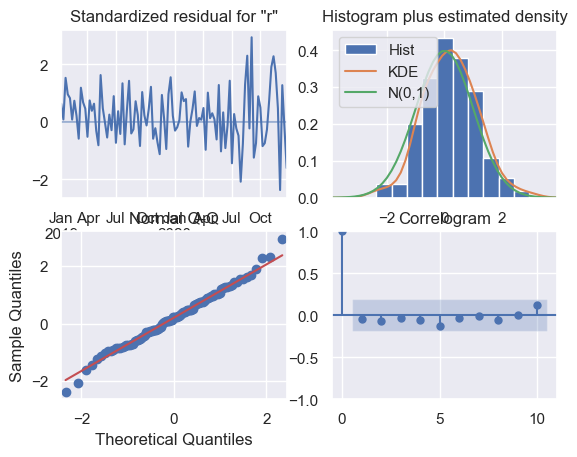

In [24]:
arima_results.plot_diagnostics()
plt.show()

Let's analyse the disgnostics plot:
- There is no obvious pattern for standardized residual (good);
- KDE line is almost close to the normal distribution line (good enough);
- Most of the correlations for lag greater than one are not significant (good);


In [25]:
model_auto = pm.arima.auto_arima(
    sales_per_week,
    max_p=26,
    max_q=26,
    max_P=26,
    max_Q=26,
    max_order=26,
    m=1,
    seasonal=True,
    stationary=False,
    information_criterion="aic",
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=True,
)

model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.679, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3062.860, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3041.364, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3030.553, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3060.865, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3027.248, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3039.080, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3030.873, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3032.492, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3037.435, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3029.782, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.737 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1509.624
Date:                Fri, 15 Nov 2024   AIC                           3027.248
Time:                        23:19:53   BIC                           3037.825
Sample:                    12-31-2018   HQIC                          3031.533
                         - 12-28-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5208.6573   2218.020      2.348      0.019     861.418    9555.897
ar.L1          0.3020      0.105      2.876      0.004       0.096       0.508
ma.L1         -0.9888      0.082    -12.098      0.000      -1.149      -0.829
sigma2      2.679e+11   6.65e-05   4.03e+15      0.000    2.68e+11    2.68e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.30   Prob(JB):                         0.40
Heteroskedasticity (H):               2.94   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.17e+30. Standard errors may be unstable.
"""

In [26]:
arima_model_auto = SARIMAX(sales_per_week.astype(float), order=(1, 1, 1))

arima_auto_results = arima_model_auto.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44307D+01    |proj g|=  2.59479D-02

At iterate    5    f=  1.44250D+01    |proj g|=  1.04927D-01

At iterate   10    f=  1.43990D+01    |proj g|=  8.85171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   1.571D-06   1.440D+01
  F =   14.398960077677124     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


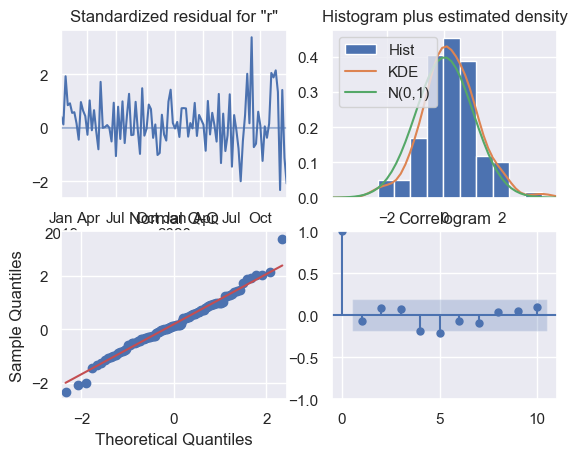

In [ ]:
arima_auto_results.plot_diagnostics()

## Forecast

In [28]:
arima_pred = arima_results.get_prediction(start=-26, dynamic=False)
arima_mean_0 = arima_pred.predicted_mean

arima_auto_pred = arima_auto_results.get_prediction(start=-26, dynamic=False)
arima_auto_mean = arima_auto_pred.predicted_mean

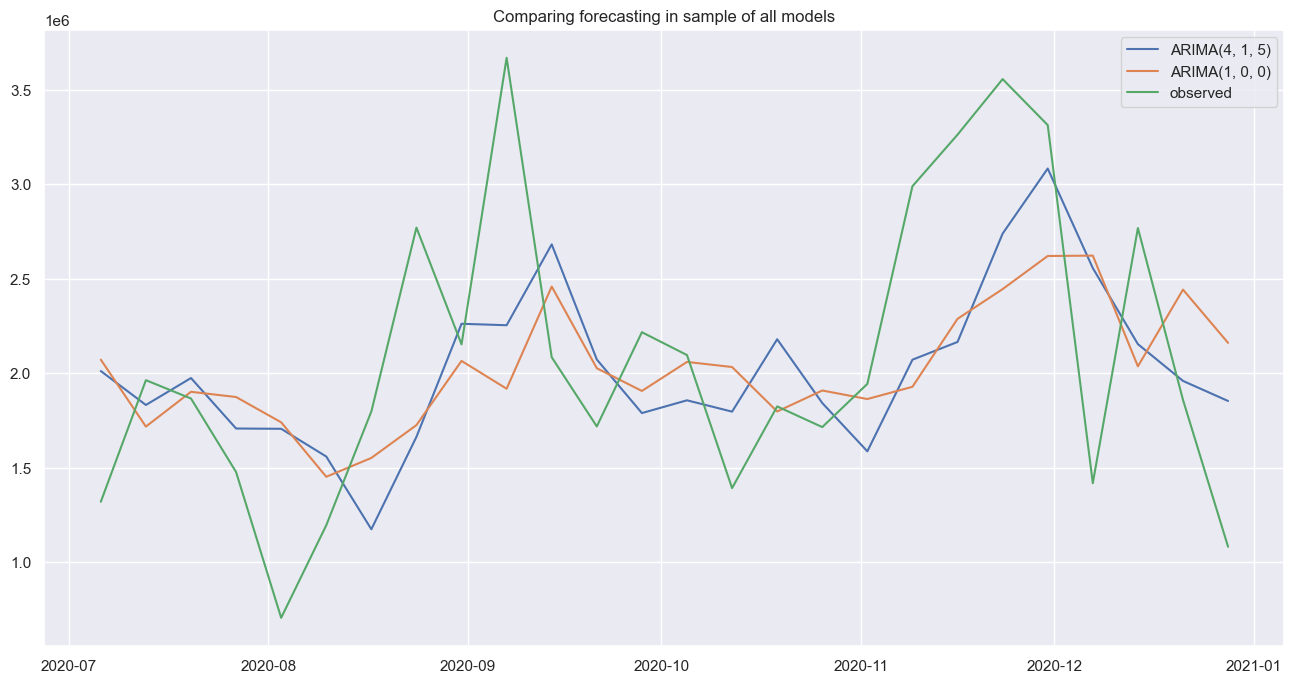

In [29]:
plt.figure(figsize=(16, 8))
plt.title("Comparing forecasting in sample of all models")
plt.plot(arima_mean_0.index, arima_mean_0, label="ARIMA(4, 1, 5)")
plt.plot(arima_auto_mean.index, arima_auto_mean, label="ARIMA(1, 0, 0)")
plt.plot(sales_per_week[-26:], label="observed")
plt.legend()
plt.show()

In [30]:
arima_forecast = arima_results.get_forecast(steps=52, dynamic=False)
arima_mean = arima_forecast.predicted_mean
arima_conf_int = arima_forecast.conf_int(alpha=0.10)

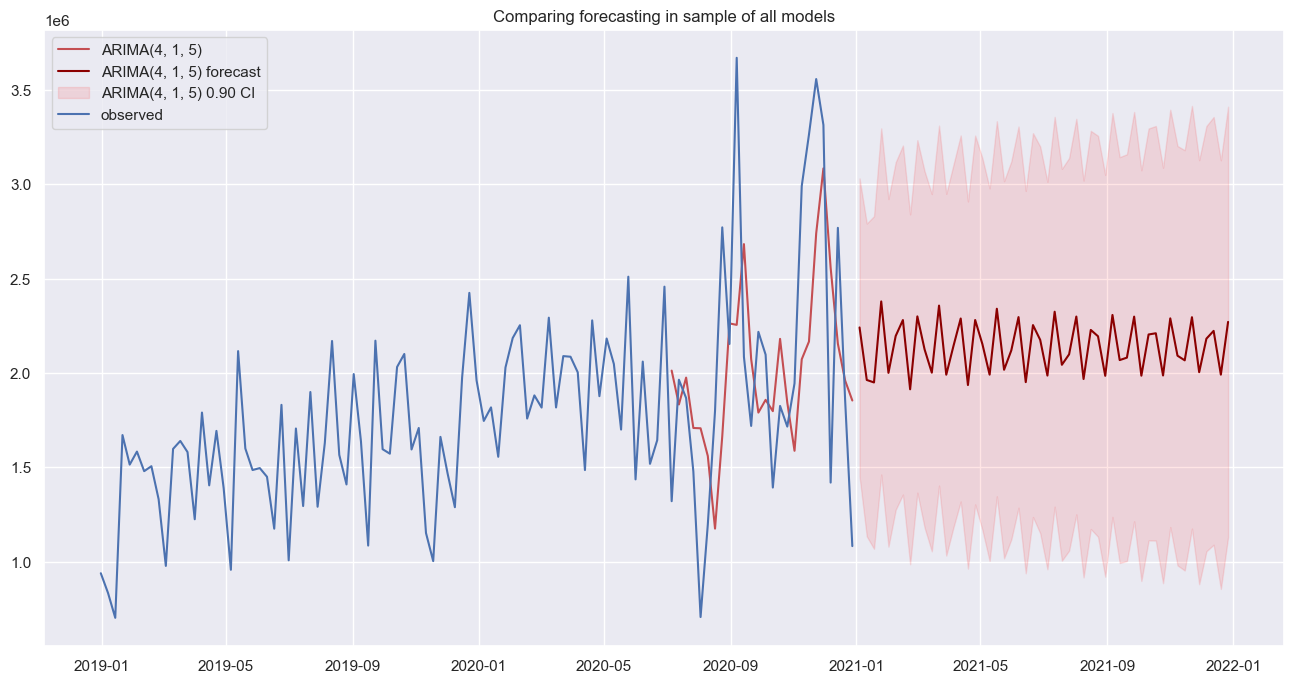

In [31]:
plt.figure(figsize=(16, 8))
plt.title("Comparing forecasting in sample of all models")
plt.plot(arima_mean_0.index, arima_mean_0, label="ARIMA(4, 1, 5)", color="r")
plt.plot(arima_mean.index, arima_mean, label="ARIMA(4, 1, 5) forecast", color="darkred")
plt.fill_between(
    arima_conf_int.index,
    arima_conf_int["lower revenue"],
    arima_conf_int["upper revenue"],
    label="ARIMA(4, 1, 5) 0.90 CI",
    color="red",
    alpha=0.1,
)

plt.plot(sales_per_week, label="observed")
plt.legend();

## Revenue the next year

In [32]:
revenue_2021 = pd.DataFrame(arima_mean)

revenue_2021.index.name = "week"
revenue_2021.columns = ["predicted_revenue"]
revenue_2021["month"] = revenue_2021.index.to_period("M")

revenue_2021 = (revenue_2021.groupby("month").sum() / 10**6).transpose()

revenue_2021.head()

month,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12
predicted_revenue,8.531579,8.389116,10.772248,8.647528,10.619166,8.6752,8.451485,10.672723,8.754105,8.385414,10.745547,8.665239


In [33]:
print(revenue_2021.to_markdown())

|                   |   2021-01 |   2021-02 |   2021-03 |   2021-04 |   2021-05 |   2021-06 |   2021-07 |   2021-08 |   2021-09 |   2021-10 |   2021-11 |   2021-12 |
|:------------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| predicted_revenue |   8.53158 |   8.38912 |   10.7722 |   8.64753 |   10.6192 |    8.6752 |   8.45149 |   10.6727 |   8.75411 |   8.38541 |   10.7455 |   8.66524 |
